# eXponential Family Dynamical Systems (XFADS): Large-scale nonlinear Gaussian state-space modeling

<a target="_blank" href="https://colab.research.google.com/github/catniplab/xfads/blob/workshop/workshop/monkey_reaching/main.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<br>Approximate inference targeted at variational Gaussian state-space models with dense covariance matrix approximations.  For more details, see our paper: [Dowling, Zhao, Park. 2024](https://arxiv.org/abs/2403.01371)

This is a walk-through for the minimal functioning of XFADS. We will be building a toy model on the [MC_Maze](https://neurallatents.github.io/datasets.html) dataset as a benchmark, which is a delayed center-out reaching task with barriers.<br>
With the adequate configs, you can fit XFADS on different spans of neural data.

In [575]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import random

from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import torch
import pytorch_lightning as lightning

from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from mc_utils import *

from hydra import compose, initialize
from xfads import plot_utils
from xfads.smoothers.lightning_trainers import LightningMonkeyReaching
from xfads.ssm_modules.prebuilt_models import create_xfads_poisson_log_link

NameError: name 'n_neurons_obs' is not defined

In [25]:
torch.cuda.empty_cache()

In [27]:
initialize(version_base=None, config_path="", job_name="monkey_reaching")
cfg = compose(config_name="config")

In [29]:
lightning.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)

Seed set to 1236


# Loading the data
The data is already in the GitHub repo; so it should've been downloaded (in `./data`) with the clone. But if you want to download it manullay, run `download_data.py`. Or you can download it directly from DANDI: [MC_Maze_Medium](https://dandiarchive.org/dandiset/000139).

In [32]:
data_path = 'data/data_{split}_{bin_sz_ms}ms.pt'
train_data = torch.load(data_path.format(split='train', bin_sz_ms=cfg.bin_sz_ms))
val_data = torch.load(data_path.format(split='valid', bin_sz_ms=cfg.bin_sz_ms))
test_data = torch.load(data_path.format(split='test', bin_sz_ms=cfg.bin_sz_ms))

y_train_obs = train_data['y_obs'].type(torch.float32).to(cfg.data_device)
y_valid_obs = val_data['y_obs'].type(torch.float32).to(cfg.data_device)
y_test_obs = test_data['y_obs'].type(torch.float32).to(cfg.data_device)

vel_train = train_data['velocity'].type(torch.float32).to(cfg.data_device)
vel_valid = val_data['velocity'].type(torch.float32).to(cfg.data_device)
vel_test = test_data['velocity'].type(torch.float32).to(cfg.data_device)

y_train_dataset = torch.utils.data.TensorDataset(y_train_obs, vel_train)
y_val_dataset = torch.utils.data.TensorDataset(y_valid_obs, vel_valid)
y_test_dataset = torch.utils.data.TensorDataset(y_test_obs, vel_test)

train_dataloader = torch.utils.data.DataLoader(y_train_dataset, batch_size=cfg.batch_sz, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(y_val_dataset, batch_size=y_valid_obs.shape[0], shuffle=False)
test_dataloader = torch.utils.data.DataLoader(y_test_dataset, batch_size=y_valid_obs.shape[0], shuffle=False)

# Data dimensions
n_train_trials, n_time_bins, n_neurons_obs = y_train_obs.shape
n_valid_trials = y_valid_obs.shape[0]
n_test_trials = y_test_obs.shape[0]
n_time_bins_enc = train_data['n_time_bins_enc']

n_bins_bhv = 10  # at t=n_bins_bhv start forecast
move_onset = 12  # stimulus onset

trial_list=[1, 287//4, 28//4 + 287//2, 286]

print("# training trials: {0}".format(n_train_trials))
print("# validation trials: {0}".format(n_valid_trials))
print("# testing trials: {0}".format(n_test_trials))
print("# neurons: {0}".format(n_neurons_obs))
print("# time bins: {0}".format(n_time_bins))
print("# time bins used for forcasting: {0}".format(n_bins_bhv))
print("# predicted time bins: {0}".format(n_time_bins_enc))

# training trials: 1721
# validation trials: 287
# testing trials: 287
# neurons: 182
# time bins: 45
# time bins used for forcasting: 10
# predicted time bins: 35


In [34]:
train_data.keys()

dict_keys(['y_obs', 'velocity', 'n_neurons_enc', 'n_neurons_obs', 'n_time_bins_enc'])

In [38]:
train_data.keys()

dict_keys(['y_obs', 'velocity', 'n_neurons_enc', 'n_neurons_obs', 'n_time_bins_enc'])

In [40]:
train_data['y_obs'].shape

torch.Size([1721, 45, 182])

# Structuring the State-Space Model

The configuration depends on the problem - `dynamics_mod`, `initial_c_pdf`, `likelihood_pdf`, `local_encoder`, and `backward_encoder` can be configured as desired. We include some general classes in `ssm_modules/encoders`, `ssm_modules/likelihoods` and `ssm_modules/dynamics` that should be sufficient for a wide range of problems.  Below is an example configuration.

In [76]:
"""create ssm"""
ssm = create_xfads_poisson_log_link(cfg, n_neurons_obs, train_dataloader, model_type='n')

"""lightning"""
seq_vae = LightningMonkeyReaching(ssm, cfg, n_time_bins_enc, n_bins_bhv)
csv_logger = CSVLogger('logs/smoother/acausal/', name=f'sd_{cfg.seed}_r_y_{cfg.rank_local}_r_b_{cfg.rank_backward}', version='smoother_acausal')
ckpt_callback = ModelCheckpoint(save_top_k=3, monitor='r2_valid_enc', mode='max', dirpath='ckpts/smoother/acausal/', save_last=True,
                                filename='{epoch:0}_{valid_loss:0.2f}_{r2_valid_enc:0.2f}_{r2_valid_bhv:0.2f}_{valid_bps_enc:0.2f}')

## Training and saving the model

In [78]:
trainer = lightning.Trainer(max_epochs=cfg.n_epochs,
                            gradient_clip_val=1.0,
                            default_root_dir='lightning/',
                            callbacks=[ckpt_callback],
                            logger=csv_logger,
                            )

trainer.fit(model=seq_vae, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)
torch.save(ckpt_callback.best_model_path, 'ckpts/smoother/acausal/best_model_path.pt')
trainer.test(dataloaders=test_dataloader, ckpt_path='last')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/lightning_fabric/loggers/csv_logs.py:269: Experiment logs directory logs/smoother/acausal/sd_1236_r_y_15_r_b_5/smoother_acausal exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /Users/mahmoud/catnip/xfads/workshop/monkey_reaching/ckpts/smoother/acausal exists and is not empty.

  | Name | Type                            | Params | Mode 
-----------------------------------------------------------------
0 | ssm  | LowRankNonlinearStateSpaceModel | 604 K  | train
-----------------------------------------------------------------
604 K     Trainable params
0         Non-trainable params
604 K     Total params
2.420     Total estimated model param

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/4 [00:00<?, ?it/s] 

/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
Restoring states from the checkpoint path at /Users/mahmoud/catnip/xfads/workshop/monkey_reaching/ckpts/smoother/acausal/last.ckpt


RuntimeError: Error(s) in loading state_dict for LightningMonkeyReaching:
	Unexpected key(s) in state_dict: "best_ssm_enc.nl_filter.dynamics_mod.log_Q", "best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.weight_ih", "best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.weight_hh", "best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.bias_ih", "best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.bias_hh", "best_ssm_enc.nl_filter.dynamics_mod.mean_fn.h_to_z.weight", "best_ssm_enc.nl_filter.dynamics_mod.mean_fn.h_to_z.bias", "best_ssm_enc.nl_filter.dynamics_mod.mean_fn.z_to_h.weight", "best_ssm_enc.nl_filter.dynamics_mod.mean_fn.z_to_h.bias", "best_ssm_enc.nl_filter.initial_c_pdf.m_0", "best_ssm_enc.nl_filter.initial_c_pdf.log_Q_0", "best_ssm_enc.dynamics_mod.log_Q", "best_ssm_enc.dynamics_mod.mean_fn.gru_cell.weight_ih", "best_ssm_enc.dynamics_mod.mean_fn.gru_cell.weight_hh", "best_ssm_enc.dynamics_mod.mean_fn.gru_cell.bias_ih", "best_ssm_enc.dynamics_mod.mean_fn.gru_cell.bias_hh", "best_ssm_enc.dynamics_mod.mean_fn.h_to_z.weight", "best_ssm_enc.dynamics_mod.mean_fn.h_to_z.bias", "best_ssm_enc.dynamics_mod.mean_fn.z_to_h.weight", "best_ssm_enc.dynamics_mod.mean_fn.z_to_h.bias", "best_ssm_enc.local_encoder.mlp.0.weight", "best_ssm_enc.local_encoder.mlp.0.bias", "best_ssm_enc.local_encoder.mlp.3.weight", "best_ssm_enc.local_encoder.mlp.3.bias", "best_ssm_enc.initial_c_pdf.m_0", "best_ssm_enc.initial_c_pdf.log_Q_0", "best_ssm_enc.likelihood_pdf.readout_fn.1.weight", "best_ssm_enc.likelihood_pdf.readout_fn.1.bias", "best_ssm_enc.backward_encoder.rnn.weight_ih_l0", "best_ssm_enc.backward_encoder.rnn.weight_hh_l0", "best_ssm_enc.backward_encoder.rnn.bias_ih_l0", "best_ssm_enc.backward_encoder.rnn.bias_hh_l0", "best_ssm_enc.backward_encoder.projection.weight", "best_ssm_enc.backward_encoder.projection.bias", "best_ssm_bhv.nl_filter.dynamics_mod.log_Q", "best_ssm_bhv.nl_filter.dynamics_mod.mean_fn.gru_cell.weight_ih", "best_ssm_bhv.nl_filter.dynamics_mod.mean_fn.gru_cell.weight_hh", "best_ssm_bhv.nl_filter.dynamics_mod.mean_fn.gru_cell.bias_ih", "best_ssm_bhv.nl_filter.dynamics_mod.mean_fn.gru_cell.bias_hh", "best_ssm_bhv.nl_filter.dynamics_mod.mean_fn.h_to_z.weight", "best_ssm_bhv.nl_filter.dynamics_mod.mean_fn.h_to_z.bias", "best_ssm_bhv.nl_filter.dynamics_mod.mean_fn.z_to_h.weight", "best_ssm_bhv.nl_filter.dynamics_mod.mean_fn.z_to_h.bias", "best_ssm_bhv.nl_filter.initial_c_pdf.m_0", "best_ssm_bhv.nl_filter.initial_c_pdf.log_Q_0", "best_ssm_bhv.dynamics_mod.log_Q", "best_ssm_bhv.dynamics_mod.mean_fn.gru_cell.weight_ih", "best_ssm_bhv.dynamics_mod.mean_fn.gru_cell.weight_hh", "best_ssm_bhv.dynamics_mod.mean_fn.gru_cell.bias_ih", "best_ssm_bhv.dynamics_mod.mean_fn.gru_cell.bias_hh", "best_ssm_bhv.dynamics_mod.mean_fn.h_to_z.weight", "best_ssm_bhv.dynamics_mod.mean_fn.h_to_z.bias", "best_ssm_bhv.dynamics_mod.mean_fn.z_to_h.weight", "best_ssm_bhv.dynamics_mod.mean_fn.z_to_h.bias", "best_ssm_bhv.local_encoder.mlp.0.weight", "best_ssm_bhv.local_encoder.mlp.0.bias", "best_ssm_bhv.local_encoder.mlp.3.weight", "best_ssm_bhv.local_encoder.mlp.3.bias", "best_ssm_bhv.initial_c_pdf.m_0", "best_ssm_bhv.initial_c_pdf.log_Q_0", "best_ssm_bhv.likelihood_pdf.readout_fn.1.weight", "best_ssm_bhv.likelihood_pdf.readout_fn.1.bias", "best_ssm_bhv.backward_encoder.rnn.weight_ih_l0", "best_ssm_bhv.backward_encoder.rnn.weight_hh_l0", "best_ssm_bhv.backward_encoder.rnn.bias_ih_l0", "best_ssm_bhv.backward_encoder.rnn.bias_hh_l0", "best_ssm_bhv.backward_encoder.projection.weight", "best_ssm_bhv.backward_encoder.projection.bias". 

## Loading the trained model

In [89]:
"""lightning"""
model_ckpt_path = 'ckpts/smoother/acausal/best_model_path.pt'
seq_vae = LightningMonkeyReaching.load_from_checkpoint(model_ckpt_path, ssm=ssm, cfg=cfg,
                                                       n_time_bins_enc=n_time_bins_enc, n_time_bins_bhv=n_bins_bhv,
                                                       strict=False)
"""extract trained ssm from lightning module"""
seq_vae.ssm = seq_vae.ssm.to(cfg.device)

In [91]:
z_s_train = []
z_s_valid = []
z_f_valid = []
z_p_valid = []
stats_valid = []

for batch in train_dataloader:
    
    loss, z, stats = seq_vae.ssm(batch[0], cfg.n_samples)
    z_s_train.append(z)

for batch in valid_dataloader:
    
    z_f, stats = seq_vae.ssm.fast_filter_1_to_T(batch[0], cfg.n_samples)
    loss, z, stats = seq_vae.ssm(batch[0], cfg.n_samples)
    
    z_p = seq_vae.ssm.predict_forward(z_f[:, :, 10], cfg.n_samples)
    z_p = torch.cat([z_f[:, :, :10], z_p], dim=2)
    
    z_f_valid.append(z_f)
    z_p_valid.append(z_p)
    z_s_valid.append(z)
    stats_valid.append(stats)

In [21]:
z.shape

torch.Size([25, 287, 45, 40])

In [95]:
U, S, V = torch.svd(seq_vae.ssm.likelihood_pdf.readout_fn[-1].weight.data)
V = S.unsqueeze(-1) * V

z_s_train = torch.cat(z_s_train, dim=1)
z_s_valid = torch.cat(z_s_valid, dim=1)
z_f_valid = torch.cat(z_f_valid, dim=1)
z_p_valid = torch.cat(z_p_valid, dim=1)

z_s_train = z_s_train[..., :cfg.n_latents_read] @ V
z_s_test = z_s_valid[..., :cfg.n_latents_read] @ V
z_f_test = z_f_valid[..., :cfg.n_latents_read] @ V
z_p_test = z_p_valid[..., :cfg.n_latents_read] @ V

In [96]:
"""colors"""
blues = cm.get_cmap("winter", z_s_test.shape[0])
reds = cm.get_cmap("summer", z_s_test.shape[0])
springs = cm.get_cmap("spring", z_s_test.shape[0])

color_map_list = [blues, reds, springs]

/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_29987/2082696959.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blues = cm.get_cmap("winter", z_s_test.shape[0])
/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_29987/2082696959.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  reds = cm.get_cmap("summer", z_s_test.shape[0])
/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_29987/2082696959.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  

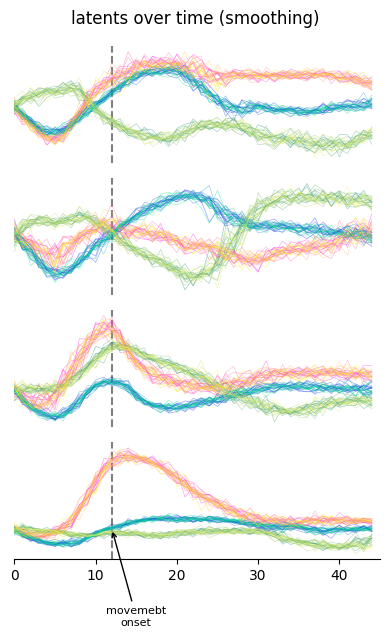

In [101]:
"""smoothed"""
with torch.no_grad():

    fig, axs = plt.subplots(len(trial_list), 1, figsize=(4, 6))
    plot_z_samples(fig, axs, z_s_test[:, trial_list, ..., -3:], color_map_list)
    #fig.suptitle('First 3 latents over time, for all neurons, from 4 test trials \n (smoothing regime) \n')
    fig.suptitle('latents over time (smoothing)')
    fig.tight_layout()
    
    plt.annotate('movemebt\nonset', xy=(12, 0), xytext=(3+12, -30),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    # fig.savefig('plots/z_s_test.png', bbox_inches='tight', transparent=True)
    
    plt.show()

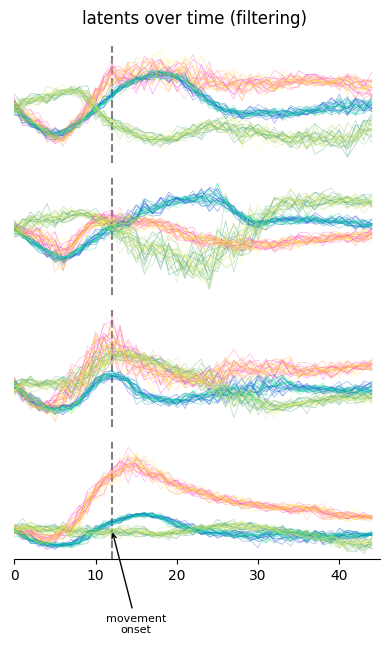

In [30]:
"""filtered"""
with torch.no_grad():

    fig, axs = plt.subplots(len(trial_list), 1, figsize=(4, 6))
    plot_z_samples(fig, axs, z_f_test[:, trial_list, ..., -3:], color_map_list)
    #fig.suptitle('First 3 latents over time, for all neurons, from 4 test trials \n(filtering regime) \n')
    fig.suptitle('latents over time (filtering)')
    fig.tight_layout()
    
    plt.annotate('movement\nonset', xy=(12, 0), xytext=(3+12, -30),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    # fig.savefig('plots/z_f_test.png', bbox_inches='tight', transparent=True)
    
    plt.show()

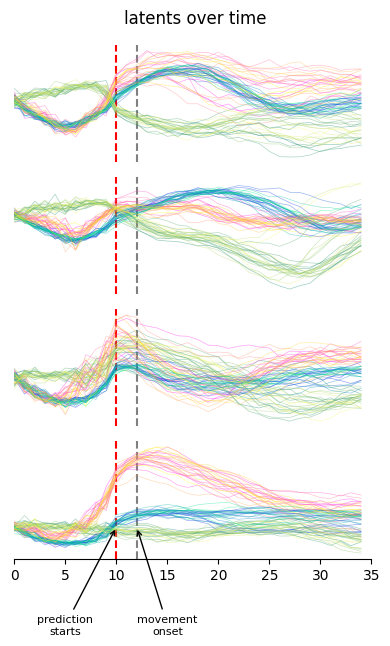

In [31]:
"""predicted"""
with torch.no_grad():

    fig, axs = plt.subplots(len(trial_list), 1, figsize=(4, 6))
    [axs[i].axvline(10, linestyle='--', color='red') for i in range(len(trial_list))]
    plot_z_samples(fig, axs, z_p_test[:, trial_list, ..., -3:], color_map_list)
    #fig.suptitle('First 3 latents over time, for all neurons, from 4 test trials \n(prediction regime) \n')
    fig.suptitle('latents over time')
    fig.tight_layout()
    
    plt.annotate('prediction\nstarts', xy=(10, 0), xytext=(5, -30),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    plt.annotate('movement\nonset', xy=(12, 0), xytext=(3+12, -30),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    # fig.savefig('plots/z_p_test.png', bbox_inches='tight', transparent=True)
    
    plt.show()

# Evaluating Model Performance
The most trivial way to start with is just to plot the training and validation losses. Good we have the logs!

In [33]:
# reading the logs

logs_path = 'logs/smoother/acausal/sd_1236_r_y_15_r_b_5/smoother_acausal/metrics.csv'
metrics = pd.read_csv(logs_path).to_dict()

In [34]:
metrics.keys()

dict_keys(['epoch', 'r2_test_bhv', 'r2_test_enc', 'r2_train_enc', 'r2_valid_bhv', 'r2_valid_enc', 'step', 'test_bps_bhv', 'test_bps_enc', 'test_loss', 'time_forward', 'train_bps_enc', 'train_loss', 'valid_bps_bhv', 'valid_bps_enc', 'valid_loss'])

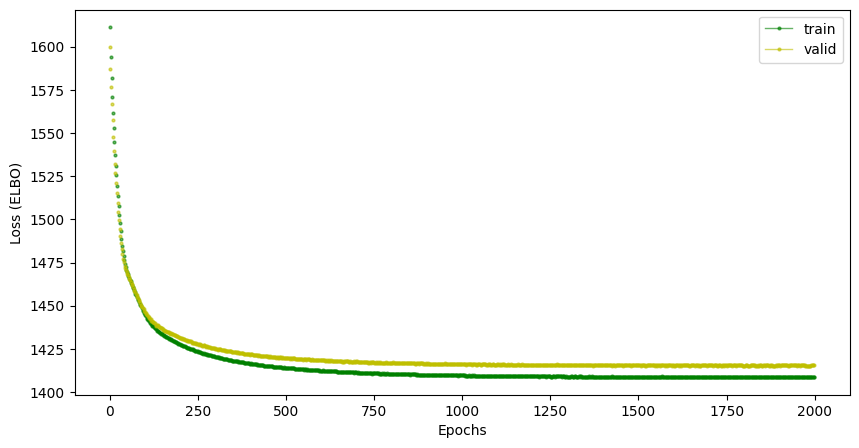

In [35]:
# Plot the training and validation loss

plt.figure(figsize=(10, 5))

plt.plot(
    metrics['train_loss'].keys(),
    metrics['train_loss'].values(),
    marker='o', markersize=2, linestyle='-', color='g', alpha=0.6, linewidth=1, label='train')

plt.plot(
    metrics['valid_loss'].keys(),
    metrics['valid_loss'].values(),
    marker='o', markersize=2, linestyle='-', color='y', alpha=0.6, linewidth=1, label='valid')

# plt.title('Training and Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (ELBO)')

plt.legend()

# plt.savefig('plots/loss.png', bbox_inches='tight', transparent=True)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


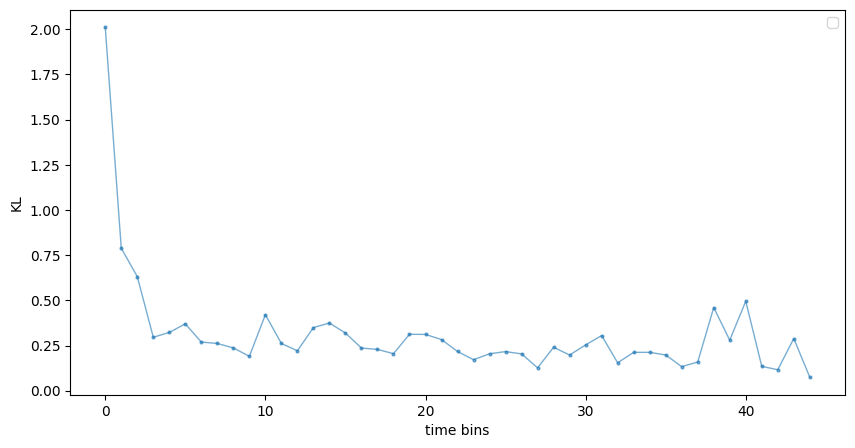

In [36]:
# Plot the training and validation loss

plt.figure(figsize=(10, 5))

with torch.no_grad():
    plt.plot(
        stats['kl'][286],
        marker='o', markersize=2, linestyle='-', alpha=0.6, linewidth=1)

plt.xlabel('time bins')
plt.ylabel('KL')

plt.legend()
plt.show()

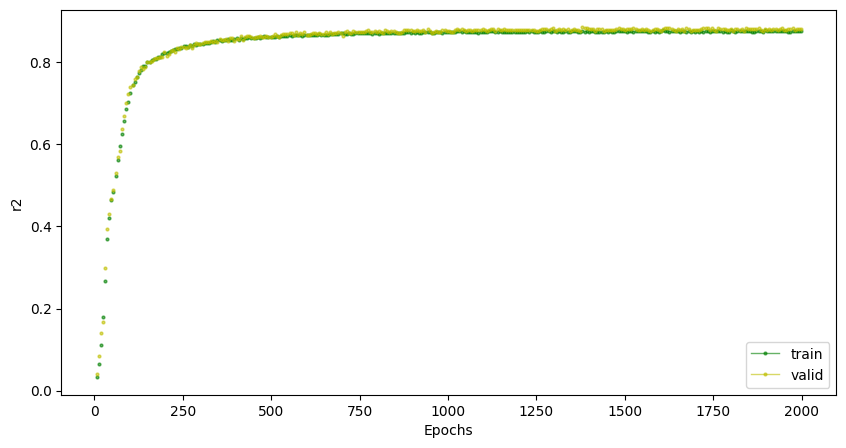

In [64]:
# Plot the training and validation loss

plt.figure(figsize=(10, 5))

plt.plot(
    list(metrics['r2_train_enc'].keys())[1:],
    list(metrics['r2_train_enc'].values())[1:],
    marker='o', markersize=2, linestyle='-', color='g', alpha=0.6, linewidth=1, label='train')

plt.plot(
    list(metrics['r2_valid_enc'].keys())[1:],
    list(metrics['r2_valid_enc'].values())[1:],
    marker='o', markersize=2, linestyle='-', color='y', alpha=0.6, linewidth=1, label='valid')

#plt.title('R2')

plt.xlabel('Epochs')
plt.ylabel('r2')

plt.legend()

# plt.savefig('plots/r2.png', bbox_inches='tight', transparent=True)

plt.show()

Another way to evaluate model performance is the **Bits per Spike (BpS)**. Which is a quantification of how neurons encode information.

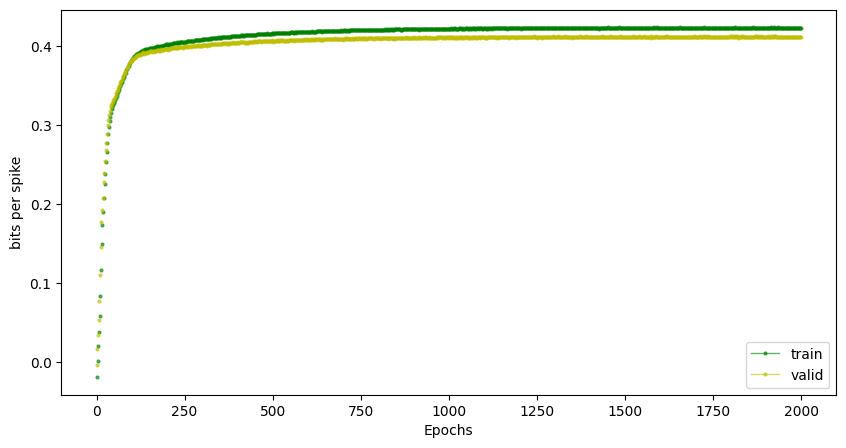

In [67]:
# Plot the training and validation loss

plt.figure(figsize=(10, 5))

plt.plot(
    metrics['train_bps_enc'].keys(),
    metrics['train_bps_enc'].values(),
    marker='o', markersize=2, linestyle='-', color='g', alpha=0.6, linewidth=1, label='train')

plt.plot(
    metrics['valid_bps_enc'].keys(),
    metrics['valid_bps_enc'].values(),
    marker='o', markersize=2, linestyle='-', color='y', alpha=0.6, linewidth=1, label='valid')

# plt.title('Bits per Spike for Training and Validation')

plt.xlabel('Epochs')
plt.ylabel('bits per spike')

plt.legend()

# plt.savefig('plots/bps.png', bbox_inches='tight', transparent=True)

plt.show()

The previous plots were all about the evolution of the model performance throughout training (loss x epochs). Aonther way to evaluate how the model captures the tuning properties of neurons relative to the stimulus over time is to look at the **peri-stimulus time histogram (PSTH)**.

We will generate condition averaged (in our example, conditions are the reaching directions) PSTHs from the model and compare them to the condition averaged PSTHs from the data.

# Breaking down the state space model learned by XFADS

One of the main functionalities of XFADS is breaking the amortized inference step into two additive components: the `local_encoder` and the `backward_encoder`.

In [71]:
"""extract trained ssm from lightning module"""
seq_vae.ssm = seq_vae.ssm.to(cfg.device)
seq_vae.ssm.eval()

LowRankNonlinearStateSpaceModel(
  (nl_filter): NonlinearFilter(
    (dynamics_mod): DenseGaussianDynamics(
      (mean_fn): DynamicsGRU(
        (gru_cell): GRUCell(0, 128)
        (h_to_z): Linear(in_features=128, out_features=40, bias=True)
        (z_to_h): Linear(in_features=40, out_features=128, bias=True)
      )
    )
    (initial_c_pdf): DenseGaussianInitialCondition()
  )
  (dynamics_mod): DenseGaussianDynamics(
    (mean_fn): DynamicsGRU(
      (gru_cell): GRUCell(0, 128)
      (h_to_z): Linear(in_features=128, out_features=40, bias=True)
      (z_to_h): Linear(in_features=40, out_features=128, bias=True)
    )
  )
  (local_encoder): LocalEncoderLRMvn(
    (mlp): Sequential(
      (0): Linear(in_features=182, out_features=256, bias=True)
      (1): SiLU()
      (2): Dropout(p=0.4, inplace=False)
      (3): Linear(in_features=256, out_features=640, bias=True)
    )
  )
  (initial_c_pdf): DenseGaussianInitialCondition()
  (likelihood_pdf): PoissonLikelihood(
    (readout_fn): 

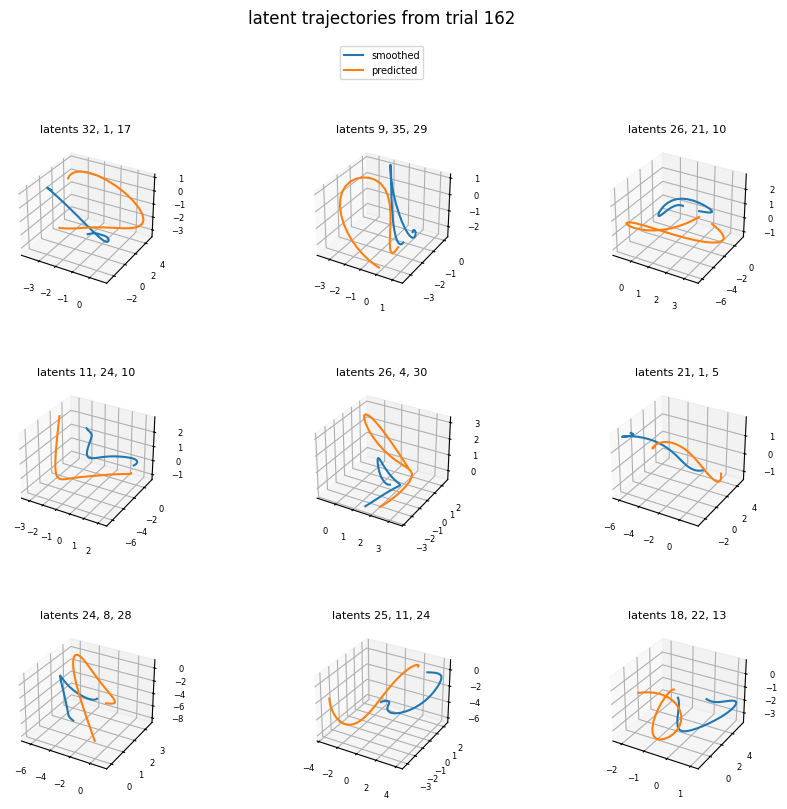

In [441]:
with torch.no_grad():
    
    trial_idx = np.random.randint(0, n_valid_trials)
    
    n_trajectories_to_plot = 9
    n_latents_to_plot = 3

    fig, axes = plt.subplots(int(np.sqrt(n_trajectories_to_plot)), int(np.sqrt(n_trajectories_to_plot)), figsize=(10, 8), subplot_kw={'projection': '3d'})
    fig.tight_layout()
    fig.suptitle(f'latent trajectories from trial {trial_idx+1}\n\n\n\n')
    
    for i, ax in enumerate(axes.flat):
        
        latent1, latent2, latent3 = np.random.choice(range(0, cfg.n_latents_read), size=n_latents_to_plot, replace=False)
        
        # Select three latent dimensions for 3D plotting
        x = torch.tensor(gaussian_filter1d(torch.mean(z_s_test[:, trial_idx, ..., latent1], dim=0), sigma=4, axis=0))
        y = torch.tensor(gaussian_filter1d(torch.mean(z_s_test[:, trial_idx, ..., latent2], dim=0), sigma=4, axis=0))
        z = torch.tensor(gaussian_filter1d(torch.mean(z_s_test[:, trial_idx, ..., latent3], dim=0), sigma=4, axis=0))

        ax.plot(x, y, z, label='smoothed' if i == 0 else '')
        
        x_p = torch.tensor(gaussian_filter1d(torch.mean(z_p_test[:, trial_idx, ..., latent1], dim=0), sigma=4, axis=0))
        y_p = torch.tensor(gaussian_filter1d(torch.mean(z_p_test[:, trial_idx, ..., latent2], dim=0), sigma=4, axis=0))
        z_p = torch.tensor(gaussian_filter1d(torch.mean(z_p_test[:, trial_idx, ..., latent3], dim=0), sigma=4, axis=0))
        
        ax.tick_params(axis='x', labelsize=6)
        ax.tick_params(axis='y', labelsize=6)
        ax.tick_params(axis='z', labelsize=6)
        
        ax.plot(x_p, y_p, z_p, label='predicted' if i == 0 else '')
        
        ax.set_title(f'latents {latent1+1}, {latent2+1}, {latent3+1}', fontsize=8)
        #ax.set_xlabel(f'latent {latent1}', fontsize=8)
        #ax.set_ylabel(f'latent {latent2}', fontsize=8)
        #ax.set_zlabel(f'latent {latent3}', fontsize=8)
    
    plt.tight_layout()

    fig.subplots_adjust(hspace=0.6)
    
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=1, fontsize=7)

    # fig.savefig('plots/3d_trajectory.png', bbox_inches='tight', transparent=True)
    
    plt.show()


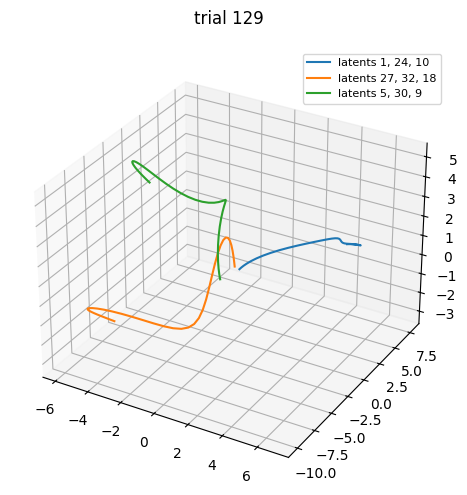

In [545]:
with torch.no_grad():

    fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': '3d'})
    fig.tight_layout()
    
    n_latents_to_plot = 3
    n_trajectories_to_plot = 3
    
    trial_idx = np.random.randint(0, z_s_test.shape[1])
    
    for i in range(n_trajectories_to_plot):
        
        # Any random 3 latents
        latent1, latent2, latent3 = np.random.choice(range(0, cfg.n_latents_read), size=n_latents_to_plot, replace=False)

        # Select three latent dimensions for 3D plotting
        x = torch.tensor(
            gaussian_filter1d(
                torch.mean(
                    z_s_test[:, trial_idx, ..., latent1], dim=0), sigma=4, axis=0))
        
        y = torch.tensor(
            gaussian_filter1d(
                torch.mean(
                    z_s_test[:, trial_idx, ..., latent2], dim=0), sigma=4, axis=0))
        
        z = torch.tensor(
            gaussian_filter1d(
                torch.mean(
                    z_s_test[:, trial_idx, ..., latent3], dim=0), sigma=4, axis=0))

        ax.plot(x, y, z, label=f'latents {latent1+1}, {latent2+1}, {latent3+1}')
        
    ax.legend(fontsize=8)
    
    fig.suptitle(f'trial {trial_idx+1}')
    plt.tight_layout()
    
    # fig.savefig('plots/3d_trajectory_in_one_fig.png', bbox_inches='tight', transparent=True)
    
    plt.show()


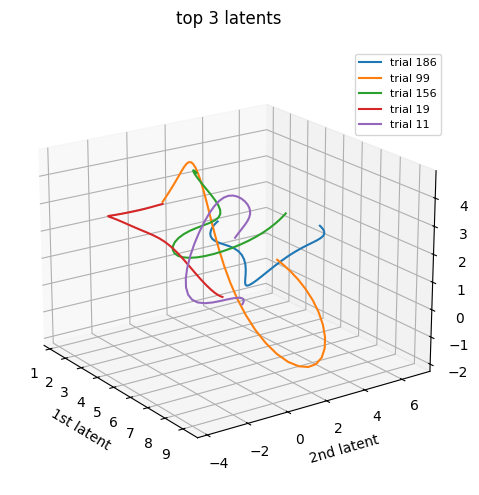

In [547]:
with torch.no_grad():

    fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': '3d'})
    fig.tight_layout()
    
    n_latents_to_plot = 3
    n_trajectories_to_plot = 5
    
    trials_inds = np.random.choice(range(0, y_valid_obs.shape[0]), size=n_trajectories_to_plot, replace=False)
    
    # top 3 latents (not indices)
    latent1, latent2, latent3 = [0, 1, 2]
    
    for i in range(n_trajectories_to_plot):

        # Select three latent dimensions for 3D plotting
        x = torch.tensor(
            gaussian_filter1d(
                torch.mean(
                    z_s_test[:, trials_inds[i], ..., latent1], dim=0), sigma=4, axis=0))
        
        y = torch.tensor(
            gaussian_filter1d(
                torch.mean(
                    z_s_test[:, trials_inds[i], ..., latent2], dim=0), sigma=4, axis=0))
        
        z = torch.tensor(
            gaussian_filter1d(
                torch.mean(
                    z_s_test[:, trials_inds[i], ..., latent3], dim=0), sigma=4, axis=0))

        ax.plot(x, y, z, label=f'trial {trials_inds[i]+1}')
        
    ax.legend(fontsize=8)
    ax.view_init(elev=20., azim=-35)
    ax.set_xlabel('1st latent')
    ax.set_ylabel('2nd latent')
    ax.set_zlabel('3rd latent')
    
    fig.suptitle(f'top 3 latents')
    plt.tight_layout()
    
    # fig.savefig('plots/3d_trajectory_in_test_trials.png', bbox_inches='tight', transparent=True)
    
    plt.show()

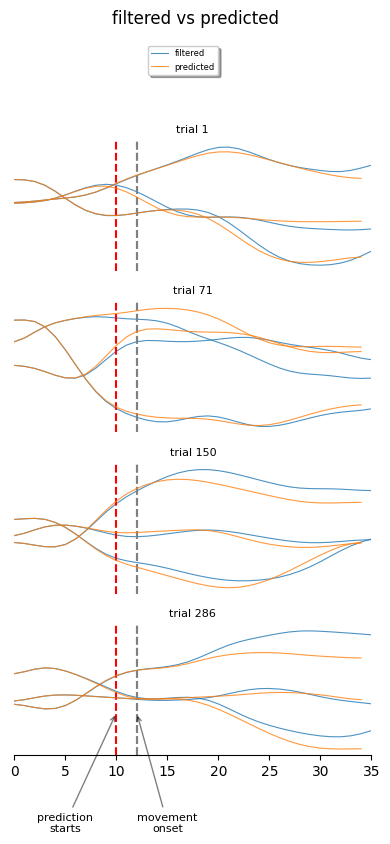

In [120]:
with torch.no_grad():

    fig, axs = plt.subplots(len(trial_list), 1, figsize=(4, 8))
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    plot_z_2d(fig, axs, trial_list, z_f_test[:, trial_list, ..., :3], color=default_colors[0], regime='filtered')
    plot_z_2d(fig, axs, trial_list, z_p_test[:, trial_list, ..., :3], color=default_colors[1], regime='predicted')
    
    #fig.suptitle('First 3 latents over time, for all neurons, from 4 test trials \n (smoothing regime) \n')
    fig.suptitle('filtered vs predicted\n\n\n\n')
    fig.tight_layout()
    
    plt.annotate('prediction\nstarts', xy=(10, 0), xytext=(5, -15),
             arrowprops=dict(facecolor='gray', arrowstyle='->', alpha=0.5),
             fontsize=8, ha='center')
    
    plt.annotate('movement\nonset', xy=(12, 0), xytext=(3+12, -15),
             arrowprops=dict(facecolor='gray', arrowstyle='->', alpha=0.5),
             fontsize=8, ha='center')
    
    fig.legend(loc='upper center', bbox_to_anchor=(0.47, 0.94), shadow=True, ncol=1, fontsize=6)
    
    # fig.savefig('plots/f_vs_p.png', bbox_inches='tight', transparent=True)
    
    plt.show()

# Generating corresponding observations
We can use the likelifood function (observation model) to generate new data (log rates) from the latents. And sampele from the rates possion to get the spike counts.

Data dimentionality:\
**generated** : sampels x trials x time bins x neurons\
sampels = samples of the latents each of which used to generate the data\
**real**: trials x time bins x neurons

In [122]:
# smoothed and predicted log rates
r_s = seq_vae.ssm.to(cfg.data_device).likelihood_pdf.readout_fn(z_s_test)
r_p = seq_vae.ssm.to(cfg.data_device).likelihood_pdf.readout_fn(z_p_test)
# sampeling from the rates possion to get the spike counts
y_s = torch.poisson(cfg.bin_sz * torch.exp(r_s))
y_p = torch.poisson(cfg.bin_sz * torch.exp(r_p))

y_hat = torch.cat([y_s[:, :, :n_bins_bhv], y_p], dim=2)
z_hat = torch.cat([z_s_test[:, :, :n_bins_bhv, :], z_p_test], dim=2)
i = 41

/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_29987/4029041241.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


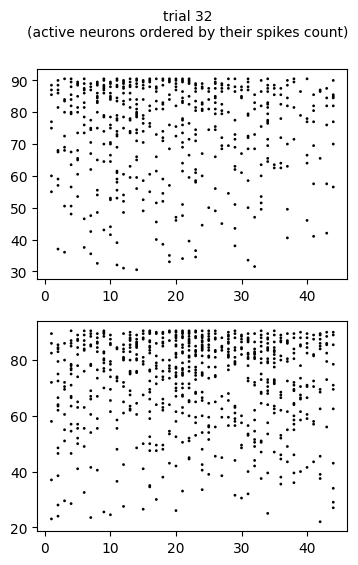

In [485]:
with torch.no_grad():
    
    trial_idx = np.random.randint(0, y_test_obs.shape[1])

    fig, axs = plt.subplots(2, 1, figsize=(4, 6))
    plot_spikes(y_test_obs[trial_idx], axs[0])
    plot_spikes(y_hat[0, trial_idx], axs[1])

    fig.suptitle(f'trial {trial_idx}\n(active neurons ordered by their spikes count)', fontsize=10)
    
    # fig.savefig('plots/generated_spikes.svg', bbox_inches='tight', transparent=True)
    
    fig.show()

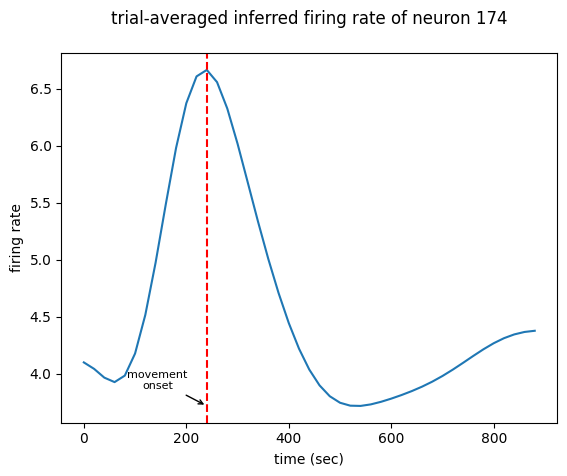

In [487]:
 with torch.no_grad():
        
    neuron_idx = np.random.randint(0, n_neurons_obs)
    
    y = torch.tensor(gaussian_filter1d(torch.mean(torch.exp(r_s)[0, :, :, neuron_idx], axis=0), sigma=2.5, axis=0))
    
    plt.plot(np.arange(n_time_bins) * cfg.bin_sz_ms, y)
    
    plt.title(f'trial-averaged inferred firing rate of neuron {neuron_idx+1}\n')
    plt.xlabel('time (sec)')
    plt.ylabel('firing rate')
    plt.axvline(x=move_onset*cfg.bin_sz_ms, color='r', linestyle='--')
    plt.annotate('movement\nonset', xy=(move_onset*cfg.bin_sz_ms, torch.min(y)), xytext=((move_onset*cfg.bin_sz_ms)*0.6, torch.min(y)+(torch.max(y)-torch.min(y))*0.05),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=8, ha='center')
    
    # plt.savefig('plots/r_s.png')
    
    plt.show()

<Figure size 1600x600 with 0 Axes>

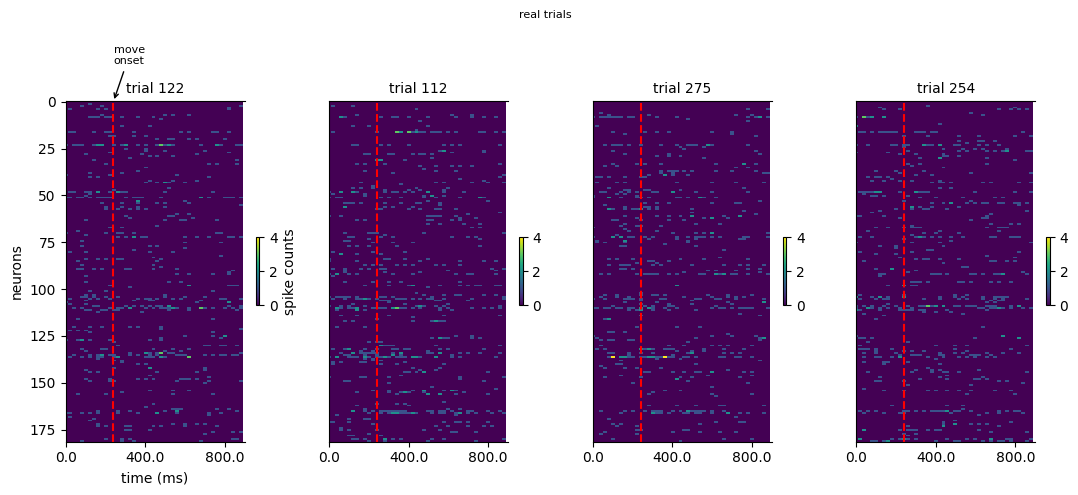

TypeError: plot_rastor() got multiple values for argument 'regime'

In [569]:
trials_inds = np.random.choice(range(0, y_valid_obs.shape[0]), size=n_trajectories_to_plot, replace=False)

plot_rastor(y_valid_obs, z_s_test, trials_inds, y_valid_obs.shape[2])
plot_rastor(y_hat[0], z_s_test, trials_inds, y_hat.shape[3], regime='prediction')

## Ordering the neurons in terms of their loading to the 1st principal latent dimension

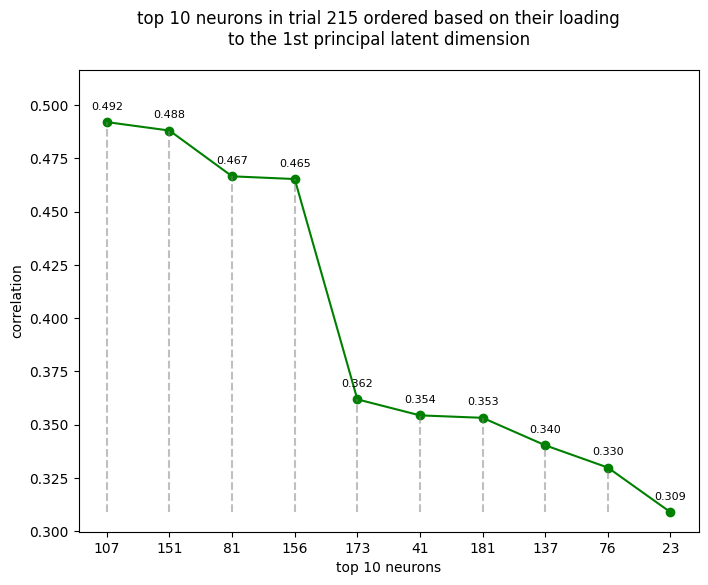

In [553]:
trial_idx = np.random.randint(0, y_valid_obs.shape[0])
ordered_correlations, ordered_neurons = order_neurons(y_valid_obs, z_s_test, trial=trial_idx, latent=0)

top_n = 10

time_bins = [str(i) for i in ordered_neurons[:top_n].astype('int32')]

y = np.abs(ordered_correlations.T[1][:top_n])

plt.ion()

fig, axes = plt.subplots(figsize=(8, 6))

axes.plot(time_bins, y, marker='o', linestyle='-', color='g')

for i in range(len(time_bins)):
    plt.text(time_bins[i], y[i]+0.005, f'{y[i]:.3f}', ha='center', va='bottom', fontsize=8)
    plt.vlines(i, ymin=y.min(), ymax=y[i], linestyles='dashed', colors='gray', alpha=0.5)

fig.suptitle(f'top 10 neurons in trial {trial_idx+1} ordered based on their loading\nto the 1st principal latent dimension\n\n\n\n')
plt.ylim(top=y.max()+0.05*y.max())

plt.xlabel('top 10 neurons')
plt.ylabel('correlation')

# fig.savefig('plots/corrcoef(averaged_samples).png')

plt.show()

<Figure size 1600x600 with 0 Axes>

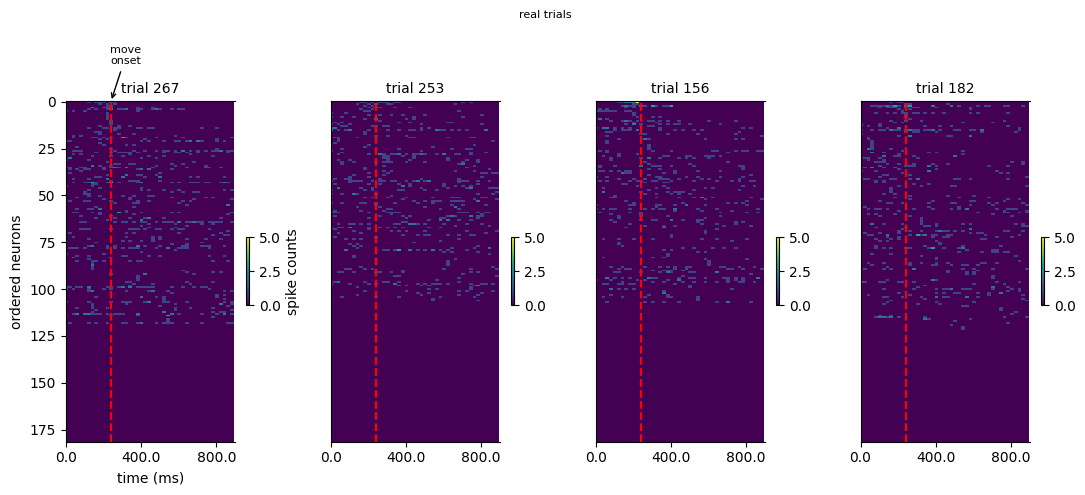

TypeError: plot_rastor() got multiple values for argument 'regime'

In [567]:
trials_inds = np.random.choice(range(0, y_valid_obs.shape[0]), size=n_trajectories_to_plot, replace=False)

plot_rastor(y_valid_obs, z_s_test, trials_inds, y_valid_obs.shape[2], order=True)
plot_rastor(y_hat[0], z_s_test, trials_inds, y_hat.shape[3], regime='prediction', order=True)

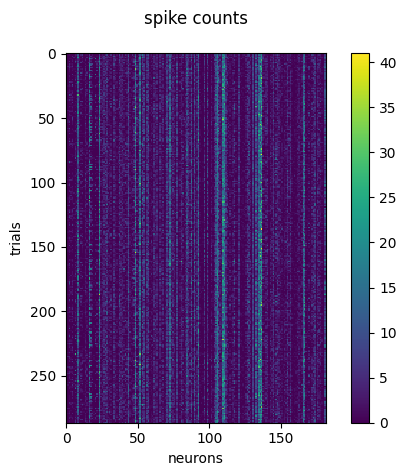

In [557]:
spike_count = torch.sum(y_valid_obs, axis=1)

plt.imshow(spike_count, interpolation='nearest', aspect=0.9)
plt.colorbar()
plt.title('spike counts\n')
plt.xlabel('neurons')
plt.ylabel('trials')

# plt.savefig('silent_vs_active_neurons.png')

plt.show()